In [ ]:
# Elliptic data - Community split
# https://www.kaggle.com/datasets/ellipticco/elliptic-data-set

In [ ]:
# https://medium.com/stanford-cs224w/fraud-detection-on-bitcoin-transaction-graphs-using-graph-convolutional-networks-5fc50a903687

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install torch_geometric
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

In [3]:
import torch_geometric

torch_geometric.__version__


'2.1.0'

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'dimgrey', 'grid.color':'lightgrey'})

import numpy as np
import pandas as pd
import networkx as nx
import torch.nn.functional as F
import torch.nn as nn
import torch_scatter
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score
import scipy.sparse as scsp
from sklearn.cluster import KMeans
import copy

In [5]:
from torch_geometric.data import Data 
from torch_geometric.utils import to_undirected

In [ ]:
# 1. import files directly from Kaggle

In [6]:
import os

In [ ]:
# create new API token, right top link on kaggle website, account, create new API token, use key from json file

In [7]:
os.environ['KAGGLE_USERNAME'] = "spribylova" # username from the json file, Account (User ID 288011)
os.environ['KAGGLE_KEY'] = "824aac185892fb6c89deeb574acff6f5" # key from the json file
!kaggle datasets download -d ellipticco/elliptic-data-set
!unzip elliptic-data-set.zip
!mkdir elliptic_bitcoin_dataset_cont

 91% 133M/146M [00:00<00:00, 195MB/s]
100% 146M/146M [00:00<00:00, 184MB/s]
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [8]:
# Load Dataframe
df_edge = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_class = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv',header=None)

# Setting Column names for features (node) file
df_features.columns = ['id', 'time step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]


In [15]:
G = nx.Graph()

In [16]:
G.add_nodes_from(df_features)

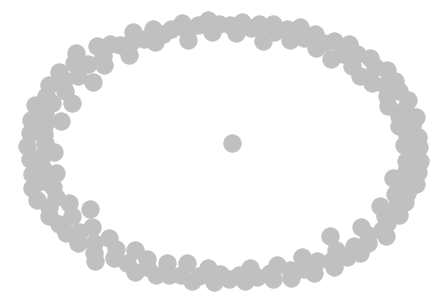

In [18]:
 nx.draw(G, node_color='silver')

In [19]:
df_edge.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [ ]:
# number of edges is 234355
df_edge.shape

(234355, 2)

In [ ]:
df_class.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [20]:
df_features.head()

,id,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
# number of nodes is 203769
df_features.shape

(203769, 167)

In [ ]:
# Create csv from Dataframe

In [ ]:
# Graph Preprocessing

In [ ]:
# We first tested standard classification models for the licit/illicit prediction using three standard approaches: 
# Logistic Regression (with default parameters from the scikit-learn Python package [4]), Random Forest (also from scikit-learn, with 50 estimators and 50 max features), 
# and Multilayer Perceptron (implemented in PyTorch). 
# Our MLP had one hidden layer of 50 neurons and was trained for 200 epochs by using the Adam optimizer and a learning rate of 0.001.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Model

In [ ]:
url_data_e = (r'https://raw.githubusercontent.com/yuchenWYC/'
              r'Elliptic_dataset/master/edges.csv')
edges = pd.read_csv(url_data_e)

url_data_n = (r'https://media.githubusercontent.com/media/yuchenWYC/'
              r'Elliptic_dataset/master/nodes.csv')
nodes = pd.read_csv(url_data_n)

In [ ]:
nodes.head()

,txId,class,timestamp,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [ ]:
nodes.shape

(46564, 168)

We can take a look at how the preprocessed dataset looks like.

In [ ]:
nodes.iloc[0:2, 0:10]

,txId,class,timestamp,2,3,4,5,6,7,8
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305


In [ ]:
edges.head()

,txId1,txId2
0,232344069,27553029
1,3881097,232457116
2,232051089,232470704
3,230473487,7089694
4,231182296,14660781


In [ ]:
edges.shape

(36624, 2)

In [ ]:
# Time-Step Splitting Script
# command to move a tensor to a device
# set the device dynamically

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def time_step_split_helper(new_nodes, new_edges):
    """
    Split the graph and store node features, edges (represented by adjacency list),
    and labels separately by timestamp t (from 1 to 49).

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list

    Returns:
        features_t    A list of (|N_t|, d) feature matrices by timestamp
        edge_indices  A list of (2, |E_t|) adjacency list by timestamp
        labels_t      A list of (|N_t|) labels by timestamp
    """

    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    times = new_nodes.iloc[:, 2].to_numpy()
    times = torch.LongTensor(times.reshape(len(times),))
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))

    min_t = torch.min(times) # 1
    max_t = torch.max(times) # 49
    
    # Construct nodes of the directed graph for each time step;
    # features by time step are stored in "features_t"; labels by
    # time step are stored in "labels_t"
    features_t = []
    labels_t = []
    
    # Create a dictionary where
    # <key, value> = <node_id, <<idx, node_index_in_time_t_subgraph>, <t, time_t>>>.
    id2idx = {}
    for t in range(min_t, max_t + 1):
        features_t.append(features[times == t, :])
        labels_t.append(labels[times == t])
        nodes_t = nodes_id[times == t]
        for i in range(nodes_t.shape[0]):
            id2idx[nodes_t[i].item()] = {}
            id2idx[nodes_t[i].item()]['idx'] = i
            id2idx[nodes_t[i].item()]['t'] = t

    # Construct adjacency lists of the directed graph (non-symmetric) for each time step;
    # adjacency lists for each time step are stored in "edge_indices".
    edge_idx_t = [[] for _ in range(min_t, max_t + 1)]
    for index in range(new_edges.shape[0]):   
        node1_t = id2idx[new_edges.iloc[index, 0]]['t']
        node1_idx = id2idx[new_edges.iloc[index, 0]]['idx']
        node2_t = id2idx[new_edges.iloc[index, 1]]['t']
        node2_idx = id2idx[new_edges.iloc[index, 1]]['idx']
        edge_idx_t[node1_t - 1].append([node1_idx, node2_idx]) # time_step starts from 1

    edge_indices = [torch.LongTensor(edge_idx_t[i]).t() for i in range(len(edge_idx_t))]
    return features_t, edge_indices, labels_t

In [ ]:
# Performed split of training, validation and test data: by time steps or by random spit
# The first 31 time steps are used for training the model, 36 nodes are used for validation and the last 49 for test.

In [ ]:
def time_step_split(new_nodes, new_edges, device, train_lt = 31, val_lt = 36, test_lt = 49):
    """
    Create and return the training, validation, and test set, splitted by time step,
    where each subgraph at time t is considered as an input of GCN model.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        device        Computing device
        train_lt      The last time step index of training set
        val_lt        The last time step index of validation set
        test_lt       The last time step index of test set

    Returns:
        data          A dictionary that stores training, validation, and test set,
                        each value is a list of Data object
        graph_info    A matrix where each row contains information of the time-step subgraph
                      [time_step, num_of_nodes, num_of_edges, num_of_illicit_nodes]
    """
    features_t, edge_indices, labels_t = time_step_split_helper(new_nodes, new_edges)

    graph_info = np.zeros((len(labels_t), 4), dtype = np.int64)
    for t in range(len(labels_t)):
        graph_info[t, :] = np.array([t, features_t[t].shape[0], edge_indices[t].shape[1],
                                     labels_t[t][labels_t[t] == 1].shape[0]])

    train_idx, val_idx, test_idx = [np.arange(train_lt), np.arange(train_lt, val_lt),
                                    np.arange(val_lt, test_lt)]
    train_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                       y = labels_t[idx]).to(device) for idx in train_idx ]
    val_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                     y = labels_t[idx]).to(device) for idx in val_idx ]
    test_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                      y = labels_t[idx]).to(device) for idx in test_idx ]
    data = {}
    data['train'] = train_list
    data['val'] = val_list
    data['test'] = test_list

    return data, graph_info

In [ ]:
data, graph_info = time_step_split(nodes, edges, device)
for key in data:
  print(key, len(data[key]))

train 31
val 5
test 13


In [ ]:
def time_group_split(new_nodes, new_edges, device, train_lt = 31, val_lt = 36, test_lt = 49):
    """
    Create and return the training, validation, and test set, splitted by specific
    time step intervals, where the combination of subgraphs within the time step
    interval is considered as an input of GCN model.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        device        Computing device
        train_lt      The last time step index of training set
        val_lt        The last time step index of validation set
        test_lt       The last time step index of test set

    Returns:
        data          A dictionary that stores training, validation, and test set
                        each value is one Data object
    """
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    times = new_nodes.iloc[:, 2].to_numpy()
    times = torch.LongTensor(times.reshape(len(times),))
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))
    train_idx, val_idx, test_idx = [np.arange(1, train_lt + 1),
                                    np.arange(train_lt + 1, val_lt + 1),
                                    np.arange(val_lt + 1, test_lt + 1)]
    data_names = {'train': train_idx, 'val': val_idx, 'test': test_idx}
    
    # Construct nodes of the directed graph for specific time step intervals.
    # Features are stored in the given dataset name (train/val/test) of a dictionary,
    # 'raw_data', with key "features"; labels are stored with key "labels".
    min_t = torch.min(times) # 1
    max_t = torch.max(times) # 49

    id2idx = {}
    raw_data = {}
    for name in data_names.keys():
        features_set = []
        labels_set = []
        Id_set = []
        set_index = data_names[name]
        for time in set_index:
            features_set.append(features[times == time, :])
            labels_set.append(labels[times == time])
            Id_set.append(nodes_id[times == time])
        features_set = torch.cat(features_set, 0)
        labels_set = torch.cat(labels_set, 0)
        Id_set = torch.cat(Id_set, 0)
        for i in range((Id_set).shape[0]):
            id2idx[Id_set[i].item()] = {}
            id2idx[Id_set[i].item()]['idx'] = i
            id2idx[Id_set[i].item()]['set_name'] = name
        raw_data[name] = {'features': features_set, 'labels': labels_set}


    # Construct adjacency lists of the directed graph (non-symmetric) for
    # specific time intervals. Adjacency lists are stored with key "edge_indices".
    edge_idx_set = {name: [] for name in data_names.keys()}
    for index in range(new_edges.shape[0]): 
        node1_set = id2idx[new_edges.iloc[index, 0]]['set_name']
        node1_idx = id2idx[new_edges.iloc[index, 0]]['idx']
        node2_set = id2idx[new_edges.iloc[index, 1]]['set_name']
        node2_idx = id2idx[new_edges.iloc[index, 1]]['idx']
        edge_idx_set[node1_set].append([node1_idx, node2_idx]) # time_stamp starts from 1

    for name in data_names.keys():
        raw_data[name]['edge_indices'] = torch.LongTensor(edge_idx_set[name]).t()


    # Construct the training, validation, test set by 'raw_data' and store
    # in a dictionary, 'data'.
    data = {}
    for name in data_names.keys():
        data[name] = Data(x = raw_data[name]['features'],
                          edge_index = raw_data[name]['edge_indices'],
                          y = raw_data[name]['labels']).to(device)
    return data

In [ ]:
data2 = time_group_split(nodes, edges, device)
data2

{'train': Data(x=[27615, 166], edge_index=[2, 21045], y=[27615]),
 'val': Data(x=[5328, 166], edge_index=[2, 4003], y=[5328]),
 'test': Data(x=[13621, 166], edge_index=[2, 11576], y=[13621])}

In [ ]:
for key in data2:
  print(key, len(data2[key]))

train 3
val 3
test 3


In [ ]:
# Random Splitting Script


def random_split_transd(new_nodes, new_edges, train_size, test_size, device, seed = 42):

    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep edge_index known for all sets.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set
        device        Computing device
        seed          Random seed for data splitting

    Returns:
        data          A Data object that stores node features, edge_index, and labels
        dict          A dictionary that stores training, validation, test set node indices
    """
    
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))
    nodes_id = new_nodes.iloc[:, 0].to_numpy()

    # Create a dictionary that maps nodeId to index in the dataframe.
    id2idx = {}
    for i in range(new_nodes.shape[0]):
        id2idx[new_nodes.iloc[i, 0]] = i

    # Construct edge_index with same node indexing as in features and labels
    edge_idx = np.zeros((2, new_edges.shape[0]), dtype = np.int64)
    for index in range(new_edges.shape[0]):   
        node1 = id2idx[new_edges.iloc[index, 0]]
        node2 = id2idx[new_edges.iloc[index, 1]]
        edge_idx[:, index] = [node1, node2]
    edge_index = torch.LongTensor(edge_idx)

    train_index, test_index = train_test_split(np.arange(labels.shape[0]),
                                               test_size = 1 - train_size,
                                               random_state = 42)
    val_index, test_index = train_test_split(test_index,
                                             test_size = test_size / (1 - train_size),
                                             random_state = 42)

    # Construct the training, validation, test set and store
    # in a dictionary, 'data'.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = Data(x = features, edge_index = edge_index, y = labels).to(device)
                  
    return data, {'train': train_index, 'val': val_index, 'test': test_index}

In [ ]:
node_sum = nodes.shape[0]
train_node_size = np.sum(graph_info[0: 31, 1]) / node_sum
test_node_size = np.sum(graph_info[36:, 1]) / node_sum
data3, split_idx3 = random_split_transd(nodes, edges, train_size = train_node_size,
                                        test_size = test_node_size, device = device)
data3

Data(x=[46564, 166], edge_index=[2, 36624], y=[46564])

In [ ]:
train_node_size, test_node_size

(0.5930547203848466, 0.29252212009277556)

In [ ]:
def random_split_ind(new_nodes, new_edges, train_size, test_size, device, seed = 42):
    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep only the node-induced edges within
    each set.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set
        device        Computing device
        seed          Random seed for data splitting

    Returns:
        data          A dictionary that stores training, validation, and test set
                        each value is one Data object
    """
    ## Create PyG graph separated by time (merge graphs in each set in train/val/test).
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))

    # Create random splitting node indices.
    nodes_id_train, nodes_id_test, train_idx, test_idx = \
        train_test_split(nodes_id, range(nodes_id.shape[0]), test_size = 1 - train_size,
                         random_state = seed)
    nodes_id_valid, nodes_id_test, val_idx, test_idx = \
        train_test_split(nodes_id_test, test_idx, test_size = test_size / (1 - train_size),
                         random_state = seed)
    features_set = {'train': features[train_idx], 'val': features[val_idx],
                    'test': features[test_idx]}
    labels_set = {'train': labels[train_idx], 'val': labels[val_idx],
                  'test': labels[test_idx]}

    # Find the induced edge indices by the given node indices.
    id2idx = {}
    for i in range(nodes_id_train.shape[0]):
        id2idx[int(nodes_id_train[i])] = (i, 'train')
    for i in range(nodes_id_valid.shape[0]):
        id2idx[int(nodes_id_valid[i])] = (i, 'val')
    for i in range(nodes_id_test.shape[0]):
        id2idx[int(nodes_id_test[i])] = (i, 'test')   

    edge_index = {'train': [], 'val': [], 'test': []}
    for i in range(new_edges.shape[0]):
        node1 = id2idx[new_edges.iloc[i, 0]]
        node2 = id2idx[new_edges.iloc[i, 1]]
        if (node1[-1] == 'train' and node2[-1] == 'train'):
            edge_index['train'].append([node1[0], node2[0]])
        elif (node1[-1] == 'val' and node2[-1] == 'val'):
            edge_index['val'].append([node1[0], node2[0]])
        elif (node1[-1] == 'test' and node2[-1] == 'test'):
            edge_index['test'].append([node1[0], node2[0]])

    data = {}
    for name in ['train', 'val', 'test']:
        edge_index[name] = torch.LongTensor(edge_index[name]).t()
        data[name] = Data(x = features_set[name], edge_index = edge_index[name],
                          y = labels_set[name]).to(device)
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']
                  
    return data

In [ ]:
data4 = random_split_ind(nodes, edges, train_size = train_node_size,
                         test_size = test_node_size, device = device)
data4

{'train': Data(x=[27615, 166], edge_index=[2, 12937], y=[27615]),
 'val': Data(x=[5328, 166], edge_index=[2, 428], y=[5328]),
 'test': Data(x=[13621, 166], edge_index=[2, 3205], y=[13621])}

In [ ]:
# Community Splitting Script


def laplacian(A, alpha = 0.1):
    """
    Returns the Laplacian matrix of the given adjacency matrix. For the directed
    acyclic graph (not connected) with adjacency matrix A, we define a modified
    Laplacian matrix as follows:
            A_tilde = (1 - alpha) * (A + A^T) + alpha * 11^T
            L = I - D_tilde^{-1/2} A_tilde D_tilde^{-1/2}
    Args:
        A             Adjacency matrix of certain graph
        alpha         Smoothing constant that prevents isolated nodes

    Returns:
        L             Modified Laplacian matrix of the adjacency matrix A
    """
    # A is sparse, csr format
    A = (1 - alpha) * (A + A.T) + alpha * scsp.csr_matrix(np.outer(np.ones(A.shape[0]), np.ones(A.shape[0])))
    D = scsp.diags(np.asarray(np.sum(A, axis = 0)).reshape(-1) ** (-1/2))
    L = scsp.diags(np.ones(A.shape[0])) - D @ A @ D
    return L

def adj_list_to_mtx(n, edge_index):
    """
    Create a csr-format adjacency matrix by the given adjacency list.
    Args:
        n             The number of nodes in the graph
        edge_index    The (2, |E|) adjacency list of the graph

    Returns:
        a csr-format adjacency matrix
    """
    edge_mtx = np.zeros((n, n))
    for i in range(edge_index.shape[1]):
        node1 = int(edge_index[0, i])
        node2 = int(edge_index[1, i])
        edge_mtx[node1, node2] = 1

    return scsp.csr_matrix(edge_mtx)

def nearest_sum(arr, target):
    """ 
    Get a combination of numbers in the given array that sums nearest to 
    the target number.
    
    Args:
        arr      The given array
        target   The target number

    Returns:
        resid           The residual between the summation and the target number
        elt_idx_list    The indices of the subarray for summation
    """

    n = len(arr)
    opt_arr = np.zeros((n + 1, target + 1))
    for i in range(1, n + 1):
        opt_arr[i, :] = opt_arr[i-1, :]
        for j in np.arange(target, 0, step = -1):
            if opt_arr[i, j] > 0 and j + arr[i - 1] <= target:
                opt_arr[i, j + arr[i - 1]] += 1
        opt_arr[i, arr[i - 1]] += 1
    
    elt_list = []
    elt_idx_list = []
    target_sum = target
    idx = n
    if (opt_arr[idx, target] == 0):
        while opt_arr[idx, target_sum] == 0:
            print(target_sum)
            target_sum -= 1
    resid = target - target_sum

    while (idx > 0 and target_sum != 0):
        if (opt_arr[idx, target_sum] - opt_arr[idx - 1, target_sum] > 0):
            elt_list.append(arr[idx - 1])
            elt_idx_list.append(idx - 1)
            target_sum -= arr[idx - 1]
        idx = idx - 1
    return resid, elt_idx_list

In [ ]:
def community_split_transd(new_nodes, new_edges, train_size, test_size, device):
    """
    Create and return the training, validation, and test set by merging small
    clusters of the graphs. Keep edge_index known for all sets.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set

    Returns:
        data          A Data object that stores node features, edge_index, and labels
        dict          A dictionary that stores training, validation, test set node indices
    """
    cluster_num = 500
    features_t, edge_indices, labels_t = time_step_split_helper(new_nodes, new_edges)

     # Construct the features, labels, and edge_index
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))
    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    # Create a dictionary that maps nodeId to index in the dataframe.
    id2idx = {}
    for i in range(new_nodes.shape[0]):
        id2idx[new_nodes.iloc[i, 0]] = i
    # Construct edge_index with same node indexing as in features and labels
    edge_idx = np.zeros((2, new_edges.shape[0]), dtype = np.int64)
    for index in range(new_edges.shape[0]):   
        node1 = id2idx[new_edges.iloc[index, 0]]
        node2 = id2idx[new_edges.iloc[index, 1]]
        edge_idx[:, index] = [node1, node2]
    edge_index = torch.LongTensor(edge_idx)

    # Perform spectral clustering on the entire graph.
    # Since the entire graph's adjacency matrix A can be written as a block
    # diagonal matrix (blocked by time steps), we can recreate the eigenvalues
    # and eigenvectors of A by the eigenvalues and eigenvectors of blocks A_1,
    # A_2, ..., A_49 of A.
    t = 0
    eval_dict = {}
    node_num = []

    for t in range(49): # max_t = 49
        n = features_t[t].shape[0]
        A = adj_list_to_mtx(n, edge_indices[t])
        L = laplacian(A)
        evals, evecs = scsp.linalg.eigsh(L, k = n // 40, which = 'SM')

        for i in range(evals.shape[0]):
            eval_dict[evals[i]] = [t, i, evecs[:, i]]
        node_num.append(n)
    
    # 'node_blk' store node indices that mark time group separation.
    node_blk = np.insert(np.cumsum(node_num), 0, 0)
    # Block diagonal matrix has the first number-of-block (i.e., 49) smallest
    # eigenvalues to be 0.
    small_evals = np.sort(np.array([*eval_dict]))[49: (49 + cluster_num)]

    node_mtx = np.zeros((node_blk[-1], cluster_num))
    for i in range(small_evals.shape[0]):
        eval = small_evals[i]
        t, _, evec = eval_dict[eval]
        node_mtx[node_blk[t]: node_blk[t + 1], i] = evec
    
    # Use K-means algorithm to create certain number of clusters (e.g., 500).
    kmeans = KMeans(n_clusters = cluster_num, init = 'random', random_state = 42,
                    n_init = 3, max_iter = 10).fit(node_mtx)
    
    comm_count = np.bincount(kmeans.labels_)

    # Split and merge the clusters into three sets by the given number of nodes
    # in each set.
    node_num = new_nodes.shape[0]
    train_num = int(np.round(node_sum * train_size))
    val_num = int(np.round(node_sum * (1 - train_size - test_size)))

    train_num_resid, train_clust_idx = nearest_sum(comm_count, train_num)
    val_test_comm_count = np.delete(comm_count, train_clust_idx)
    val_test_clust_idx = np.delete(np.arange(500), train_clust_idx)

    val_num_resid, val_clust_idx_tmp = nearest_sum(val_test_comm_count, val_num)
    val_clust_idx = val_test_clust_idx[val_clust_idx_tmp]
    test_clust_idx = np.delete(np.arange(500), np.hstack((train_clust_idx, val_clust_idx)))

    # Split node indices by their clusters into three datasets.
    train_idx = []
    val_idx = []
    test_idx = []

    train_clust_set = set(train_clust_idx)
    val_clust_set = set(val_clust_idx)
    test_clust_set = set(test_clust_idx)
    for i in range(len(kmeans.labels_)):
        if kmeans.labels_[i] in train_clust_set:
            train_idx.append(i)
        elif kmeans.labels_[i] in val_clust_set:
            val_idx.append(i)
        else:
            test_idx.append(i)

    if train_num_resid > 0:
        train_idx.append(test_idx[-train_num_resid:])
        test_idx = test_idx[:-train_num_resid]
    if val_num_resid > 0:
        val_idx.append(test_idx[-val_num_resid:])
        test_idx = test_idx[:-val_num_resid]

    train_idx = np.array(train_idx)
    val_idx = np.array(val_idx)
    test_idx = np.array(test_idx)
    
    # Construct the training, validation, test set and store
    # in a dictionary, 'data'.
    data = Data(x = features, edge_index = edge_index, y = labels).to(device)
    
    return data, {'train': train_idx, 'val': val_idx, 'test': test_idx}

In [ ]:
data5, split_idx5 = community_split_transd(nodes, edges, train_size = train_node_size,
                                    test_size = test_node_size, device = device)
data5

Data(x=[46564, 166], edge_index=[2, 36624], y=[46564])